# Project on data jobs

## Importing Liberaries

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import re


## Laoding Data 

In [2]:
df = pd.read_csv(r'Data/Raw/data_jobs.csv')

In [3]:
df.job_skills.value_counts()

job_skills
['excel']                                                                                                                                                                                                 13238
['sql']                                                                                                                                                                                                   11732
['python']                                                                                                                                                                                                 8509
['python', 'sql']                                                                                                                                                                                          4753
['sql', 'excel']                                                                                                                                             

In [4]:
df.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
343482,Software Engineer,Software Engineer,"Madrid, Spain",via BeBee,Full-time,False,Spain,2023-01-05 23:47:21,False,False,Spain,NaN,NaN,NaN,Egnyte Poland,"['java', 'spring']","{'libraries': ['spring'], 'programming': ['jav..."
497366,Data Analyst,Data Analyst,"Padua, Province of Padua, Italy",via BeBee,Full-time,False,Italy,2023-03-14 11:26:43,False,False,Italy,NaN,NaN,NaN,Michael Page,"['sql', 'python', 'sas', 'sas', 'oracle', 'aws...","{'analyst_tools': ['sas', 'tableau', 'qlik'], ..."
358202,Data Analyst,Data Analyst Intern,Singapore,via Karkidi,Full-time,False,Singapore,2023-06-27 23:35:42,False,False,Singapore,NaN,NaN,NaN,Siemens,"['go', 'python', 'r', 'sql', 'spark', 'excel',...","{'analyst_tools': ['excel', 'tableau', 'power ..."


In [5]:
df.shape

(785741, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   job_title_short        785741 non-null  object 
 1   job_title              785740 non-null  object 
 2   job_location           784696 non-null  object 
 3   job_via                785733 non-null  object 
 4   job_schedule_type      773074 non-null  object 
 5   job_work_from_home     785741 non-null  bool   
 6   search_location        785741 non-null  object 
 7   job_posted_date        785741 non-null  object 
 8   job_no_degree_mention  785741 non-null  bool   
 9   job_health_insurance   785741 non-null  bool   
 10  job_country            785692 non-null  object 
 11  salary_rate            33067 non-null   object 
 12  salary_year_avg        22003 non-null   float64
 13  salary_hour_avg        10662 non-null   float64
 14  company_name           785723 non-nu

In [7]:
df.job_schedule_type.nunique()

47

In [8]:
df['num_jobs'] = 1

## Mapping values in columns

In [9]:
job_title_mapping = {
    'Senior Data Analyst': 'Data Analyst',
    'Senior Data Scientist': 'Data Scientist',
    'Senior Data Engineer': 'Data Engineer'
}

# Apply the mapping to the 'job_title_short' column
df['job_title_short'] = df['job_title_short'].replace(job_title_mapping)

# Display the updated DataFrame to verify the changes
print(df['job_title_short'].value_counts())


job_title_short
Data Engineer                230804
Data Analyst                 225291
Data Scientist               209243
Business Analyst              49063
Software Engineer             44929
Machine Learning Engineer     14080
Cloud Engineer                12331
Name: count, dtype: int64


In [10]:

# Fill null values in 'job_schedule_type' with the mode (most frequent value)
mode_job_schedule_type = df['job_schedule_type'].mode()
if not mode_job_schedule_type.empty:
    df['job_schedule_type'] = df['job_schedule_type'].fillna(mode_job_schedule_type[0])


# Define replacement patterns
replacements = {
    r'\bfull[-\s]?time\b': 'Full-time',      # Match "full time", "full-time", "full time ", etc.
    r'\bpart[-\s]?time\b': 'Part-time',      # Match "part time", "part-time", "part time ", etc.
    r'\bcontractor\b': 'Contract',           # Match "contractor" in any case
    r'\binternship\b': 'Internship',         # Match "internship" in any case
}

# Create a function to apply replacements using regex
def replace_job_schedule_type(text):
    for pattern, replacement in replacements.items():
        if re.search(pattern, text, re.IGNORECASE):
            return replacement
    return 'Others'  # Default category if no pattern matches

# Apply the function to the 'job_schedule_type' column
df['job_schedule_type'] = df['job_schedule_type'].apply(replace_job_schedule_type)

df['job_schedule_type'].value_counts()

job_schedule_type
Full-time     728910
Contract       37124
Internship      8955
Part-time       8450
Others          2302
Name: count, dtype: int64

In [11]:
df_sorted = df.sort_values(by='job_posted_date')

# Get the first and last values of the sorted column
first_value = df_sorted['job_posted_date'].iloc[0]
last_value = df_sorted['job_posted_date'].iloc[-1]

print("First value:", first_value)
print("Last value:", last_value)

First value: 2023-01-01 00:00:04
Last value: 2023-12-31 23:59:58


## Cleaning and Processing

In [12]:


# Calculate the mean salary for each combination of job title and country
mean_salaries = df.groupby(['job_title_short', 'job_country'])['salary_year_avg'].mean().reset_index()
mean_salaries.rename(columns={'salary_year_avg': 'mean_salary'}, inplace=True)

# Merge the mean salaries back to the original DataFrame
df = df.merge(mean_salaries, on=['job_title_short', 'job_country'], how='left')

# Fill NaNs in salary_year_avg with the mean_salary based on job_title_short and job_country
df['salary_year_avg'] = df['salary_year_avg'].fillna(df['mean_salary'])

# Drop the mean_salary column as it's no longer needed
df.drop(columns=['mean_salary'], inplace=True)

# Check for any remaining NaN values
if df['salary_year_avg'].isnull().any():
    # Calculate the mean salary for each job title (ignoring country)
    mean_salaries_job_title = df.groupby('job_title_short')['salary_year_avg'].mean().reset_index()
    mean_salaries_job_title.rename(columns={'salary_year_avg': 'mean_salary'}, inplace=True)

    # Merge these mean salaries back to the original DataFrame
    df = df.merge(mean_salaries_job_title, on='job_title_short', how='left')

    # Fill the remaining NaNs in salary_year_avg with the mean_salary based on job_title_short
    df['salary_year_avg'] = df['salary_year_avg'].fillna(df['mean_salary'])

    # Drop the mean_salary column as it's no longer needed
    df.drop(columns=['mean_salary'], inplace=True)



In [13]:
df['salary_year_avg'].isnull().sum()

0

d:\Ironhack\Git\Final project\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
d:\Ironhack\Git\Final project\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
d:\Ironhack\Git\Final project\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
d:\Ironhack\Git\Final project\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
d:\Ironhack\Git\Final project\.venv\Lib\site-packages\seaborn\ax

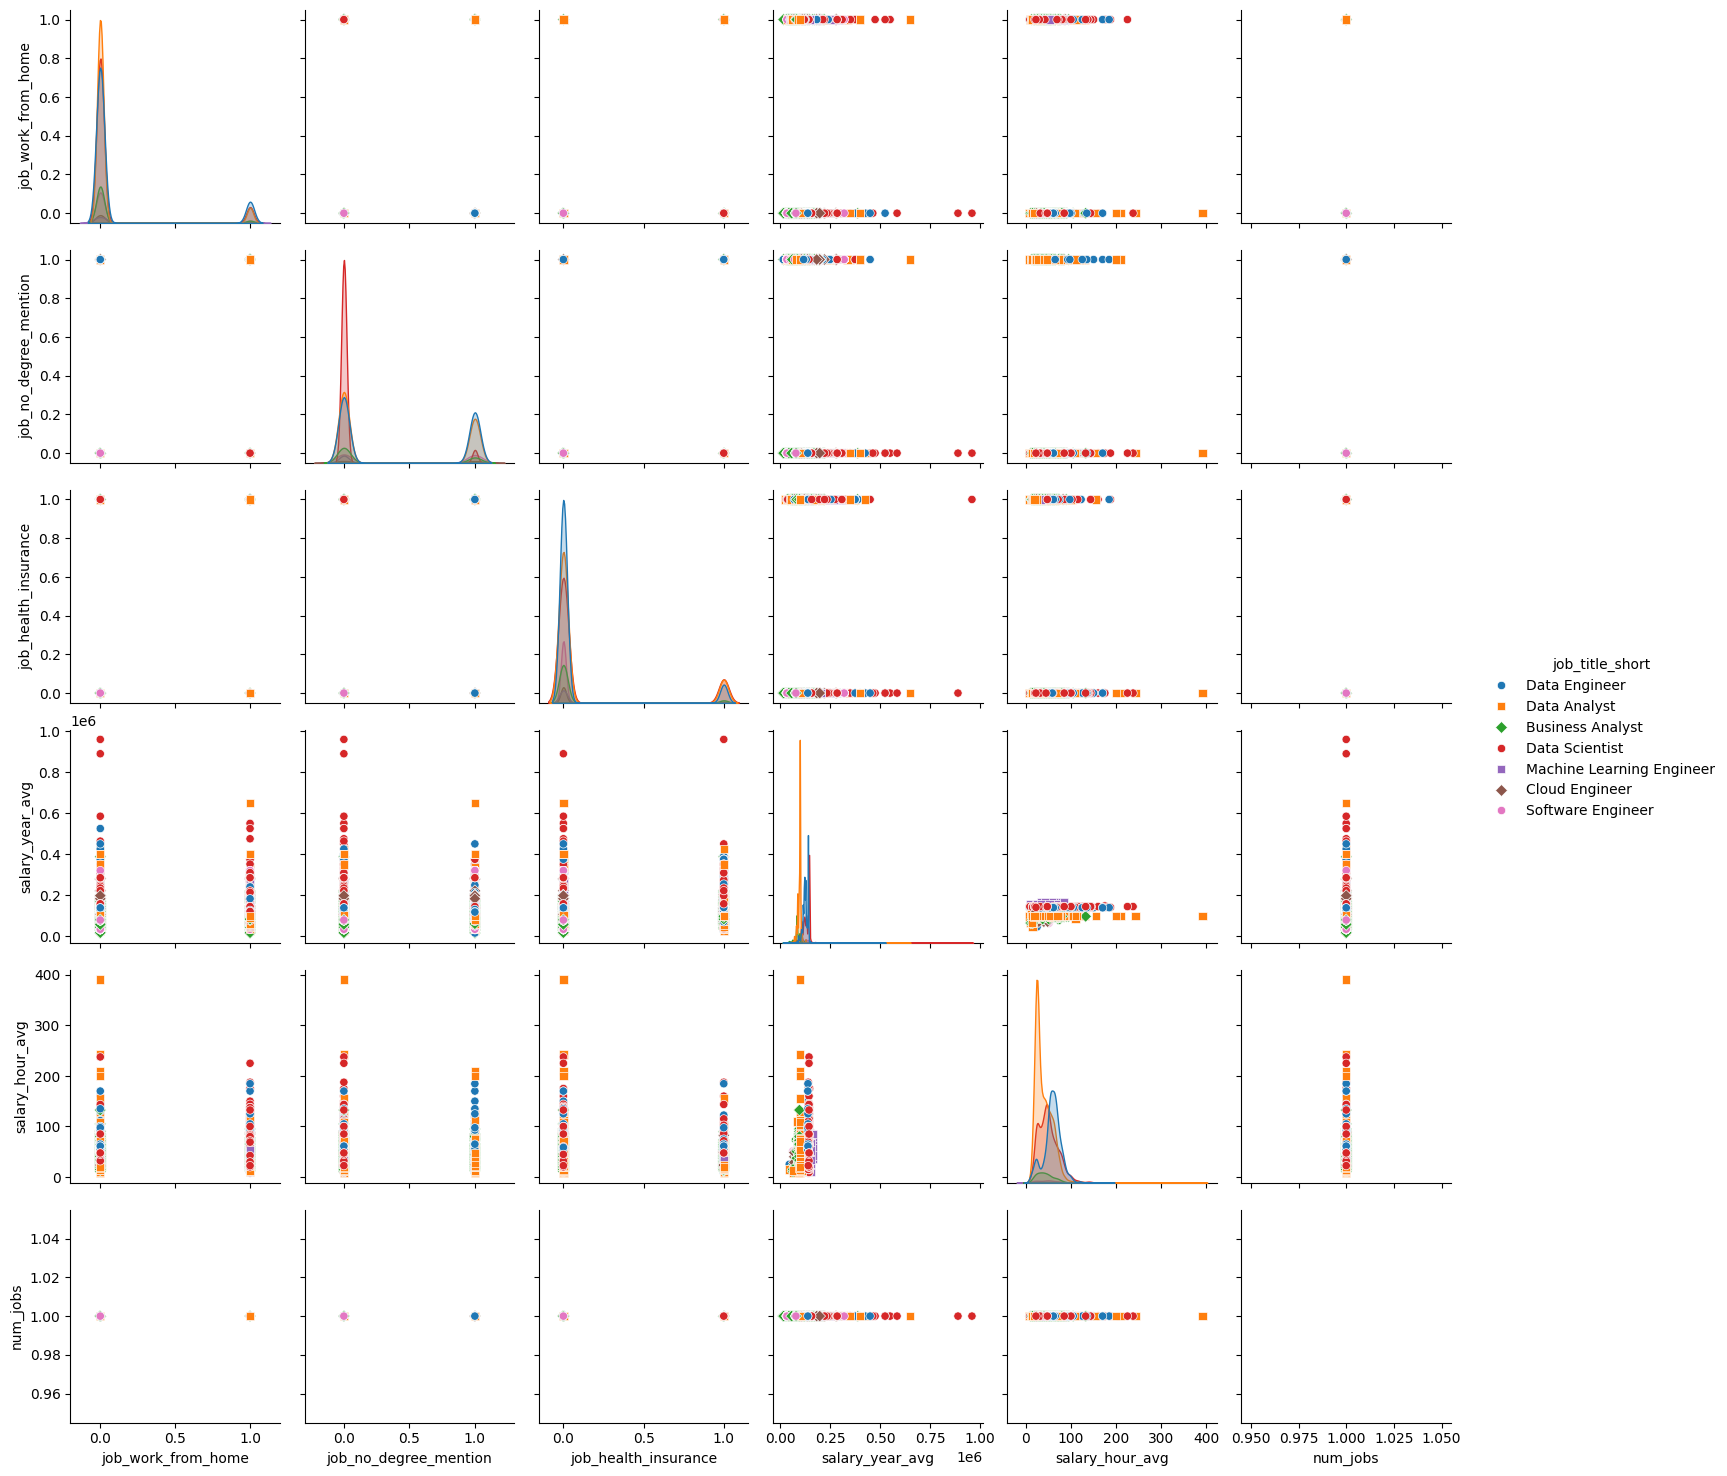

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame
sns.pairplot(df, hue='job_title_short', diag_kind='kde', markers=['o', 's', 'D'])  # 'job_country' is categorical
plt.show()


In [14]:
# Remove rows where all columns are NaN
df_cleaned = df.dropna(how='all')

# Optionally, reset the index if you want to reindex the DataFrame
df_cleaned = df_cleaned.reset_index(drop=True)

In [15]:
df_cleaned.shape

(785741, 18)

In [16]:

# Filter rows where 'job_country' is not null
df_filtered = df[df['job_country'].notna()]


# Remove rows where all other columns (except 'job_country') are null
df_cleaned = df_filtered.dropna(how='all', subset=df_filtered.columns.difference(['job_country']))

# Drop columns 'salary_rate' and 'salary_hour_avg'
df_cleaned = df_cleaned.drop(columns=['salary_rate', 'salary_hour_avg'])

# Fill null values in 'job_via' with 'Other'
df_cleaned['job_via'] = df_cleaned['job_via'].fillna('Other')

# Fill null values in 'job_location' with 'Anywhere'
df_cleaned['job_location'] = df_cleaned['job_location'].fillna('Anywhere')


# Fill null values in 'job_skills' with 'Not specified'
df_cleaned['job_skills'] = df_cleaned['job_skills'].fillna('Not specified')

# Fill null values in 'company_name' with 'Not specified'
df_cleaned['company_name'] = df_cleaned['company_name'].fillna('Not specified')

# Fill null values in 'job_skills' with 'Not specified'
df_cleaned['job_type_skills'] = df_cleaned['job_type_skills'].fillna('Not specified')

# Optionally, reset the index if you want to reindex the DataFrame
df_cleaned = df_cleaned.reset_index(drop=True)



In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785692 entries, 0 to 785691
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   job_title_short        785692 non-null  object 
 1   job_title              785692 non-null  object 
 2   job_location           785692 non-null  object 
 3   job_via                785692 non-null  object 
 4   job_schedule_type      785692 non-null  object 
 5   job_work_from_home     785692 non-null  bool   
 6   search_location        785692 non-null  object 
 7   job_posted_date        785692 non-null  object 
 8   job_no_degree_mention  785692 non-null  bool   
 9   job_health_insurance   785692 non-null  bool   
 10  job_country            785692 non-null  object 
 11  salary_year_avg        785692 non-null  float64
 12  company_name           785692 non-null  object 
 13  job_skills             785692 non-null  object 
 14  job_type_skills        785692 non-nu

In [18]:
df_cleaned.isnull().sum()

job_title_short          0
job_title                0
job_location             0
job_via                  0
job_schedule_type        0
job_work_from_home       0
search_location          0
job_posted_date          0
job_no_degree_mention    0
job_health_insurance     0
job_country              0
salary_year_avg          0
company_name             0
job_skills               0
job_type_skills          0
num_jobs                 0
dtype: int64

In [19]:
unique_counts = df_cleaned.nunique().reset_index()

# Renaming columns for clarity
unique_counts.columns = ['Column', 'Unique_Count']

# Display the result
unique_counts

,Column,Unique_Count
0,job_title_short,7
1,job_title,234646
2,job_location,17210
3,job_via,7898
4,job_schedule_type,5
5,job_work_from_home,2
6,search_location,165
7,job_posted_date,607145
8,job_no_degree_mention,2
9,job_health_insurance,2


In [20]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs
446239,Data Scientist,STAGE - Data scientist pour l'innovation,"Île-de-France, France",via Jobijoba,Full-time,False,France,2023-10-21 16:18:13,False,False,France,104993.818182,PSA Retail France,"['python', 'databricks', 'spark', 'pyspark']","{'cloud': ['databricks'], 'libraries': ['spark...",1
677905,Business Analyst,Marketing Officer,Anywhere,via Kalibrr,Full-time,True,Philippines,2023-09-07 10:13:11,False,False,Philippines,60300.000000,Data Analytics Ventures Inc. (DAVI),Not specified,Not specified,1
369167,Data Analyst,Financial Data Analyst,"Milwaukee, WI",via MyArklaMiss Jobs,Full-time,False,"Illinois, United States",2023-08-17 23:02:33,False,False,United States,98227.331003,Robert Half,"['t-sql', 'sql', 'sql server', 'ssis']","{'analyst_tools': ['ssis'], 'databases': ['sql...",1


In [21]:
df_cleaned['job_title_short'].value_counts().reset_index()

,job_title_short,count
0,Data Engineer,230798
1,Data Analyst,225281
2,Data Scientist,209237
3,Business Analyst,49057
4,Software Engineer,44912
5,Machine Learning Engineer,14078
6,Cloud Engineer,12329


In [22]:
df_cleaned['job_skills'].value_counts().reset_index().head(20)

,job_skills,count
0,Not specified,117027
1,['excel'],13237
2,['sql'],11732
3,['python'],8509
4,"['python', 'sql']",4753
5,"['sql', 'excel']",4399
6,"['sql', 'python']",4340
7,['sap'],3829
8,['go'],3429
9,"['python', 'r']",3103


In [23]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs
26592,Data Engineer,Backend Engineer (all genders) - Data Platform,"Valencia, Spain",via Jooble,Full-time,False,Spain,2023-07-09 13:55:00,True,False,Spain,118394.902174,Urban Sports Club,"['go', 'php', 'python', 'gcp', 'kubernetes']","{'cloud': ['gcp'], 'other': ['kubernetes'], 'p...",1
493169,Data Scientist,Data Scientist,"Jersey City, NJ",via The Muse,Full-time,False,"New York, United States",2023-05-06 11:02:28,False,True,United States,144098.450819,CVS Health,"['r', 'python', 'sql']","{'programming': ['r', 'python', 'sql']}",1
538891,Data Scientist,Data Scientist - Core Experience and Growth,"Lisbon, Portugal",via Wellfound,Full-time,False,Portugal,2023-05-03 19:51:26,False,False,Portugal,130617.287879,Bounce,"['sql', 'python', 'r']","{'programming': ['sql', 'python', 'r']}",1


In [24]:
df_cleaned['job_skills'].unique()

array(['Not specified',
       "['r', 'python', 'sql', 'nosql', 'power bi', 'tableau']",
       "['python', 'sql', 'c#', 'azure', 'airflow', 'dax', 'docker', 'kubernetes', 'jenkins']",
       ..., "['sql', 'bigquery', 'gdpr', 'git', 'gitlab', 'github']",
       "['sql', 'python', 'bigquery', 'aws', 'airflow', 'fastapi', 'github', 'docker']",
       "['bash', 'python', 'perl', 'linux', 'unix', 'kubernetes', 'docker', 'ansible']"],
      dtype=object)

In [25]:
# Display the DataFrame with the new num_jobs column
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs
109772,Data Analyst,Data analyst iii,"Largo, FL",via Talent.com,Full-time,False,"Florida, United States",2023-01-07 00:03:07,False,False,United States,98227.331003,Ensurem,['sql'],{'programming': ['sql']},1
564387,Data Analyst,Teamleader* Microsoft Data Analytics,"Villingen-Schwenningen, Germany",via BeBee,Full-time,False,Germany,2023-12-17 04:12:23,True,False,Germany,101085.380952,BE-terna GmbH,Not specified,Not specified,1
709891,Data Engineer,Data Engineering Application Developer,"Mumbai, Maharashtra, India",via LinkedIn,Full-time,False,India,2023-12-29 02:33:09,True,False,India,125541.000000,Accenture in India,"['python', 'gcp', 'bigquery']","{'cloud': ['gcp', 'bigquery'], 'programming': ...",1


In [26]:
df_cleaned.job_location.value_counts()

job_location
Anywhere                               70581
Singapore                              23415
Paris, France                          12311
Bengaluru, Karnataka, India            11474
London, UK                             10564
                                       ...  
East Amwell Township, NJ                   1
Macon, MO                                  1
County Durham, UK   (+2 others)            1
Bloomfield, IA                             1
Newark, New Jersey, Amerika Serikat        1
Name: count, Length: 17210, dtype: int64

In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785692 entries, 0 to 785691
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   job_title_short        785692 non-null  object 
 1   job_title              785692 non-null  object 
 2   job_location           785692 non-null  object 
 3   job_via                785692 non-null  object 
 4   job_schedule_type      785692 non-null  object 
 5   job_work_from_home     785692 non-null  bool   
 6   search_location        785692 non-null  object 
 7   job_posted_date        785692 non-null  object 
 8   job_no_degree_mention  785692 non-null  bool   
 9   job_health_insurance   785692 non-null  bool   
 10  job_country            785692 non-null  object 
 11  salary_year_avg        785692 non-null  float64
 12  company_name           785692 non-null  object 
 13  job_skills             785692 non-null  object 
 14  job_type_skills        785692 non-nu

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import concurrent.futures

# Initialize cache
cache = {}

def dms_to_decimal(dms_str):
    """Convert DMS (Degrees, Minutes, Seconds) to Decimal degrees."""
    match = re.match(r'([NSWE])\s*(\d+)[°\s]+(\d+)[′\s]+(\d+(\.\d+)?)[″\s]*', dms_str)
    if not match:
        return None
    direction, degrees, minutes, seconds, _ = match.groups()
    degrees = float(degrees)
    minutes = float(minutes)
    seconds = float(seconds)
    decimal = degrees + (minutes / 60) + (seconds / 3600)
    if direction in ['S', 'W']:
        decimal *= -1
    return decimal

def get_country_gps(country_name):
    """Fetch GPS coordinates for a given country, using cache to avoid redundant requests."""
    if country_name in cache:
        return cache[country_name]

    try:
        url = f'http://www.geonames.org/search.html?q={country_name}&country='
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            table = soup.find('table', class_='restable')
            if table:
                rows = table.find_all('tr')
                for row in rows[1:]:
                    cols = row.find_all('td')
                    if len(cols) >= 6:
                        latitude_dms = cols[4].text.strip()
                        longitude_dms = cols[5].text.strip()
                        latitude = dms_to_decimal(latitude_dms)
                        longitude = dms_to_decimal(longitude_dms)
                        result = (latitude, longitude)
                        cache[country_name] = result
                        return result

            cache[country_name] = (None, None)
            return None, None
        else:
            cache[country_name] = (None, None)
            return None, None
    except Exception as e:
        cache[country_name] = (None, None)
        return None, None

def fetch_country_data(countries):
    """Fetch GPS data for a list of countries in parallel."""
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(get_country_gps, countries))
    return dict(zip(countries, results))

# Assuming you have a DataFrame df_cleaned with a 'job_country' column
unique_countries = df_cleaned['job_country'].unique()

# Fetch GPS data for all unique countries
country_coords = fetch_country_data(unique_countries)

# Apply the cached results to the DataFrame
df_cleaned[['latitude', 'longitude']] = df_cleaned['job_country'].apply(lambda country: pd.Series(country_coords.get(country, (None, None))))




In [29]:
# Output the DataFrame with the new columns
df_cleaned.head(5)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs,latitude,longitude
0,Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,138812.678396,Boehringer Ingelheim,Not specified,Not specified,1,-14.604722,-57.656111
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,89536.405405,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr...",1,23.000000,-102.000000
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,129186.661538,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",1,51.500000,10.500000
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,United States,138812.678396,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',...",1,-14.604722,-57.656111
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,Sudan,138023.587920,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl...",1,16.000000,30.000000


In [30]:
df_cleaned.job_country.nunique()

160

In [31]:
# Check if any latitude and longitude pairs are duplicated
coordinate_pairs = df_cleaned[['latitude', 'longitude']].drop_duplicates()
print("Unique coordinate pairs count:", len(coordinate_pairs))


Unique coordinate pairs count: 160


In [32]:
# Check for countries that did not get geocoded
missing_countries = df_cleaned[df_cleaned[['latitude', 'longitude']].isna().any(axis=1)]['job_country'].unique()
print("Countries with missing coordinates:", missing_countries)

# Check for discrepancies between unique country names and coordinates
unique_countries = df_cleaned['job_country'].unique()
unique_latitudes = df_cleaned['latitude'].dropna().unique()
unique_longitudes = df_cleaned['longitude'].dropna().unique()

print("Unique countries count:", len(unique_countries))
print("Unique latitudes count:", len(unique_latitudes))
print("Unique longitudes count:", len(unique_longitudes))


Countries with missing coordinates: []
Unique countries count: 160
Unique latitudes count: 133
Unique longitudes count: 140


In [33]:
# Sample inspection of rows
df_cleaned[['job_country', 'latitude', 'longitude']].head(10)


,job_country,latitude,longitude
0,United States,-14.604722,-57.656111
1,Mexico,23.000000,-102.000000
2,Germany,51.500000,10.500000
3,United States,-14.604722,-57.656111
4,Sudan,16.000000,30.000000
5,United States,-14.604722,-57.656111
6,United States,-14.604722,-57.656111
7,Romania,46.000000,25.000000
8,Denmark,56.000000,10.000000
9,United States,-14.604722,-57.656111


In [34]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs,latitude,longitude
431870,Cloud Engineer,Senior Server Engineer,France,via BeBee,Full-time,False,France,2023-05-01 16:20:07,False,False,France,105968.000000,Bring It On,"['c#', 'mongodb', 'mongodb', 'dynamodb', 'redi...","{'analyst_tools': ['excel'], 'cloud': ['aws'],...",1,46.000000,2.00
732978,Data Scientist,Referent Data Science,"Kornwestheim, Germany",via BeBee,Full-time,False,Germany,2023-09-29 21:15:10,False,False,Germany,127918.870968,Wüstenrot Bausparkasse AG,Not specified,Not specified,1,51.500000,10.50
325982,Software Engineer,Software Engineering Lead Trainer,Singapore,via Jobs Trabajo.org,Full-time,False,Singapore,2023-08-20 17:49:58,False,False,Singapore,74283.700000,Institute of Data,"['html', 'css', 'javascript', 'sql', 'react', ...","{'libraries': ['react'], 'programming': ['html...",1,1.289444,103.85


In [35]:
# Save the DataFrame to a CSV file in the 'Data/output' folder
df_cleaned.to_csv('Data/output/df_cleaned.csv', index=False)

In [36]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs,latitude,longitude
604075,Data Analyst,Data Analyst,"Milan, Metropolitan City of Milan, Italy",via BeBee,Full-time,False,Italy,2023-04-04 09:38:29,False,False,Italy,80235.357143,Michael Page,['excel'],{'analyst_tools': ['excel']},1,42.833333,12.833333
80593,Data Scientist,USA-Data Scientist III (Clinical),California,via Recruit.net,Full-time,False,"California, United States",2023-04-02 00:03:25,False,True,United States,144098.450819,"Pyramid Consulting, Inc","['python', 'sas', 'sas', 'sql', 'r', 'gcp', 'r...","{'analyst_tools': ['sas', 'tableau', 'power bi...",1,-14.604722,-57.656111
1656,Data Engineer,Data Engineer (Network Engineer) 3 - X-Lab,"Colorado Springs, CO",via ZipRecruiter,Full-time,False,"Texas, United States",2023-08-22 13:09:25,False,True,United States,138812.678396,Boecore,"['python', 'matlab', 'go', 'postgresql', 'pand...","{'analyst_tools': ['excel', 'tableau'], 'datab...",1,-14.604722,-57.656111


In [37]:
df_cleaned.isnull().sum()

job_title_short          0
job_title                0
job_location             0
job_via                  0
job_schedule_type        0
job_work_from_home       0
search_location          0
job_posted_date          0
job_no_degree_mention    0
job_health_insurance     0
job_country              0
salary_year_avg          0
company_name             0
job_skills               0
job_type_skills          0
num_jobs                 0
latitude                 0
longitude                0
dtype: int64